<a href="https://colab.research.google.com/github/obeshor/Diabetic-Retinopathy-Detection-/blob/main/DR_MobileNet_Binary_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diabetic Retinopathy Analyzer**<br>
by Thierry Ada and Yannick Serge Obam as Mentor

15 May 2021

## Introduction

Diabetic Retinopathy (DR) is the fastest growing cause of preventable blindness. All people with diabetes are at risk. They need to be screened once a year.

This screening involves taking a picture of the back of the eye. The picture is called a fundus photo. It's taken using a special camera. An eye doctor then diagnoses this image. In many parts of the world there's a shortage of eye doctors. According to the WHO, as a result, in the world about 55% of people suffer some form of vision loss before the disease is detected.

It's now possible to take fundus photos using a cellphone camera.
https://www.jove.com/video/55958/smartphone-fundus-photography

Why not also use that same phone to automatically diagnose the photo?

The objective of this notebook is to build a binary classifier that can detect diabetic retinopathy on a fundus image. This model has been deployed on raspberry pi 3.

Fundus images can be quite large, as can be seen by the size of the images in this competition. The good thing about tensorflow.js is that there's no need to upload images. The model runs in the browser and all processing is done locally on the user's computer or mobile phone.

We will use a pre-trained MobileNet model. MobileNet was developed by Google to be small and fast.

Let's get started...

<hr>

In [ ]:
import pandas as pd
import numpy as np
import os

import cv2

from skimage.io import imread, imshow
from skimage.transform import resize

from PIL import Image

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

diabetic-retinopathy-224x224-gaussian-filtered.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  diabetic-retinopathy-224x224-gaussian-filtered.zip
replace gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png  
replace gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0369f3efe69b.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/03e25101e8e8.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/04ac765f91a1.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png  
 

In [ ]:
! ls

base_dir	 gaussian_filtered_images  model.h5   train.gsheet
dr_model.tflite  kaggle.json		   train.csv  train_images


In [ ]:
os.listdir('../Kaggle')

['train.csv',
 'kaggle.json',
 'gaussian_filtered_images',
 'train.gsheet',
 'train_images',
 'model.h5',
 'dr_model.tflite',
 'base_dir']

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [ ]:
df_train = pd.read_csv('../Kaggle/train.csv')


print(df_train.shape)

(3662, 2)


### Create a new column called file_name

In [ ]:
# Add a file_name column to df_train and df_test

def create_fname(x):

    fname = str(x) + '.png'

    return fname

df_train['file_name'] = df_train['id_code'].apply(create_fname)

In [ ]:
df_train.head()

,id_code,diagnosis,file_name
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


### Check the target distribution

In [ ]:
# Check the target distribution
df_train['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

### Visualization

In [ ]:
from pathlib import Path
import os.path

image_dir = Path('../Kaggle/gaussian_filtered_images/gaussian_filtered_images')


In [ ]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')



In [ ]:
# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,../Kaggle/gaussian_filtered_images/gaussian_fi...,Mild
1,../Kaggle/gaussian_filtered_images/gaussian_fi...,Moderate
2,../Kaggle/gaussian_filtered_images/gaussian_fi...,No_DR


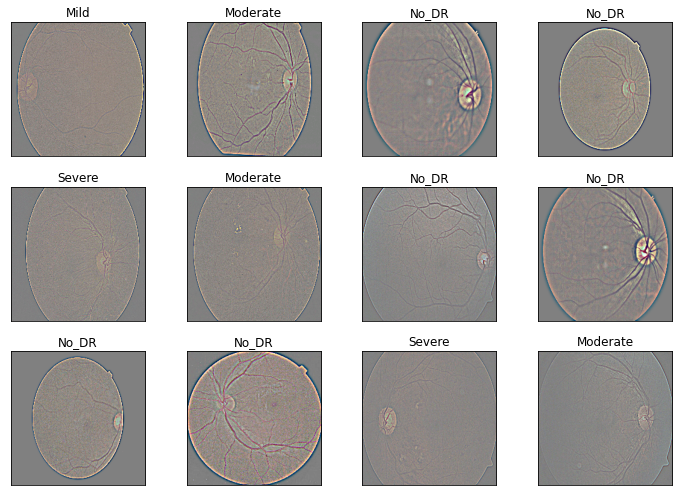

In [ ]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

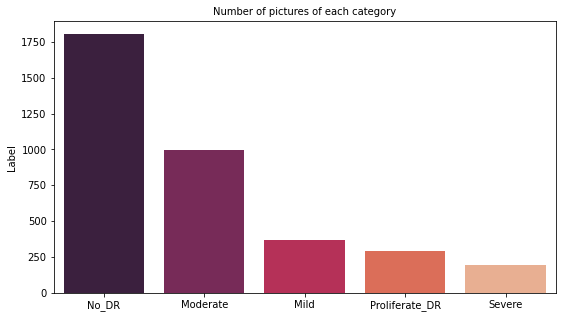

In [ ]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 10)
plt.show()

### Create Binary Targets

In [ ]:
def binary_target(x):
    if x != 0:
        return 1
    else:
        return x

df_train['binary_target'] = df_train['diagnosis'].apply(binary_target)

In [ ]:
df_train.head()

In [ ]:
# Check the target distribution

df_train['binary_target'].value_counts()

### Balance the target distribution

In [ ]:
df_0 = df_train[df_train['binary_target'] == 0]
df_1 = df_train[df_train['binary_target'] == 1].sample(len(df_0), random_state=101)


df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)

print(df_data.shape)

df_data.head()

(3610, 4)


,id_code,diagnosis,file_name,binary_target
3085,907aaff827e5,2,907aaff827e5.png,1
1173,a9dc80cba9a4,0,a9dc80cba9a4.png,0
2715,9a3c03a5ad0f,2,9a3c03a5ad0f.png,1
1419,cb39761f0712,0,cb39761f0712.png,0
177,1c47815f4a6b,0,1c47815f4a6b.png,0


In [ ]:
# Check the new target distribution

df_data['binary_target'].value_counts()

1    1805
0    1805
Name: binary_target, dtype: int64

## Train Test Split

In [ ]:
df_train, df_val = train_test_split(df_data, test_size=0.2, random_state=101)

print(df_train.shape)
print(df_val.shape)

(2888, 4)
(722, 4)


In [ ]:
# check the train set target distribution
df_train['binary_target'].value_counts()

0    1452
1    1436
Name: binary_target, dtype: int64

In [ ]:
# check the train set target distribution
df_val['binary_target'].value_counts()

1    369
0    353
Name: binary_target, dtype: int64

## Create the directory structure

In these folders we will store the resized images that will later be fed into the generators. Keras needs this directory structure in order for the generators to work.

**Key**
> 0 = No Diabetic Retinopathy<br>
> 1 = Has Diabetic Retinopathy

In [ ]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create sub folders inside 'base_dir':

# train_dir
    # a_0
    # b_1

# val_dir
    # a_0
    # b_1


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_0 = os.path.join(train_dir, 'a_0')
os.mkdir(a_0)
b_1 = os.path.join(train_dir, 'b_1')
os.mkdir(b_1)


# create new folders inside val_dir
a_0 = os.path.join(val_dir, 'a_0')
os.mkdir(a_0)
b_1 = os.path.join(val_dir, 'b_1')
os.mkdir(b_1)


In [ ]:
# Check that the folders exist
os.listdir('base_dir')

['train_dir', 'val_dir']

### Transfer the Images into the Folders

In [ ]:
df_train.head()

,id_code,diagnosis,file_name,binary_target
3361,8871e6a26596,2,8871e6a26596.png,1
1301,b92eacd1392a,0,b92eacd1392a.png,0
3317,6e73acb2cf60,4,6e73acb2cf60.png,1
2643,f0f89314e860,4,f0f89314e860.png,1
1266,b549af91bd30,0,b549af91bd30.png,0


In [ ]:
# Set the file_name as the index in df_data
df_data.set_index('file_name', inplace=True)

In [ ]:
# Get a list of train and val images
train_list = list(df_train['file_name'])

# ============================
# Transfer the train images
# ============================

for fname in train_list:

    label = df_data.loc[fname,'binary_target']

    if label == 0:
        sub_folder = 'a_0'
        # source path to image
        src = os.path.join('../Kaggle/train_images', fname)
        # destination path to image
        dst = os.path.join(train_dir, sub_folder, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)
        # save the image at the destination
        # save the image using PIL
        #result = Image.fromarray(image.astype(np.uint8))
        #result.save(dst)
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


    if label == 1:
        sub_folder = 'b_1'
        # source path to image
        src = os.path.join('../Kaggle/train_images', fname)
        # destination path to image
        dst = os.path.join(train_dir, sub_folder, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)


In [ ]:
# ============================
# Transfer the val images
# ============================

# Get a list of train and val images
val_list = list(df_val['file_name'])

for fname in val_list:

    label = df_data.loc[fname,'binary_target']

    if label == 0:
        sub_folder = 'a_0'
        # source path to image
        src = os.path.join('../Kaggle/train_images', fname)
        # destination path to image
        dst = os.path.join(val_dir, sub_folder, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)


    if label == 1:
        sub_folder = 'b_1'
        # source path to image
        src = os.path.join('../Kaggle/train_images', fname)
        # destination path to image
        dst = os.path.join(val_dir, sub_folder, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)



In [ ]:
# Check how many images are in the train sub folders

print(len(os.listdir('base_dir/train_dir/a_0')))
print(len(os.listdir('base_dir/train_dir/b_1')))

1452
1436


In [ ]:
# Check how many images are in the val sub folders

print(len(os.listdir('base_dir/val_dir/a_0')))
print(len(os.listdir('base_dir/val_dir/b_1')))

353
369


## Set Up the Generators

In [ ]:
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 5
val_batch_size = 5

# Get the number of train and val steps
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Pre-process the input images in the same way as the ImageNet images
# were pre-processed when they were used to train MobileNet.
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=train_batch_size)

val_gen = datagen.flow_from_directory(val_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
# We are only going to use this to make a prediction on the val set. That's
# why the path is set as val_path
test_gen = datagen.flow_from_directory(val_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=1,
                                            shuffle=False)

Found 2888 images belonging to 2 classes.
Found 722 images belonging to 2 classes.
Found 722 images belonging to 2 classes.


## MobileNet Pre-trained Model

In [ ]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
# The layers are set up as a list.

type(mobile.layers)

list

In [ ]:
# How many layers does MobileNet have?
len(mobile.layers)

92

In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 2 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [ ]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_0': 0, 'b_1': 1}


In [ ]:
# Add weights to try to make the model more sensitive to some classes.
# The dictionary is ordered as per the above output.

# Here the weights are set to 1 so this is not affecting the model.
# These weights can be changed later, if needed.

class_weights={
    0: 1.0, # Class 0
    1: 1.0, # Class 1
}

In [ ]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])


filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                              class_weight=class_weights,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
578/578 [==============================] - 48s 26ms/step - loss: 0.4623 - categorical_accuracy: 0.8954 - val_loss: 0.1585 - val_categorical_accuracy: 0.9571

Epoch 00001: val_categorical_accuracy improved from -inf to 0.95706, saving model to model.h5
Epoch 2/10
578/578 [==============================] - 14s 25ms/step - loss: 0.1655 - categorical_accuracy: 0.9463 - val_loss: 0.1989 - val_categorical_accuracy: 0.9321

Epoch 00002: val_categorical_accuracy did not improve from 0.95706
Epoch 3/10
578/578 [==============================] - 14s 25ms/step - loss: 0.1373 - categorical_accuracy: 0.9543 - val_loss: 0.3228 - val_categorical_accuracy: 0.9114

Epoch 00003: val_categorical_accuracy did not improve from 0.95706

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/10
578/578 [===========================

## Evaluate the model using the val set

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy']

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_categorical_accuracy = \
model.evaluate_generator(test_gen,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_categorical_accuracy:', val_categorical_accuracy)

val_loss: 0.06261592358350754
val_categorical_accuracy: 0.9806094169616699


## Plot the Training Curves

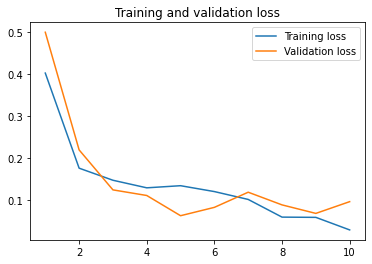

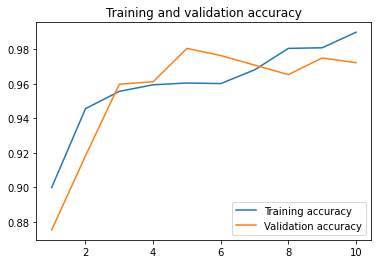

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, loss, label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()



plt.show()

## Confusion Matrix

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Print the label associated with each class
test_gen.class_indices

{'a_0': 0, 'b_1': 1}

In [ ]:
# make a prediction on the val data
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

722/722 [==============================] - 5s 6ms/step


In [ ]:
predictions.shape

(722, 2)

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(722,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_gen.class_indices

{'a_0': 0, 'b_1': 1}

Confusion matrix, without normalization
[[377   4]
 [ 10 331]]


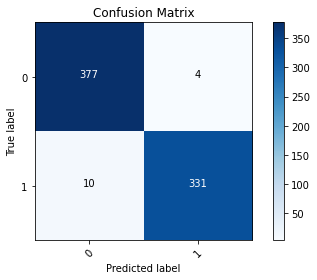

In [ ]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['0', '1']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Classification Report

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_gen.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       381
           1       0.99      0.97      0.98       341

    accuracy                           0.98       722
   macro avg       0.98      0.98      0.98       722
weighted avg       0.98      0.98      0.98       722



> **Recall** = Given a class, will the classifier be able to detect it?<br>
> **Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
> **F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

### Results

Based on the above scores, performance looks surprisingly good. Maybe too good. I hope I haven't made a mistake somewhere in the code.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

In [ ]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('base_dir')

## Convert the Model to Tensorflow Lite

In [ ]:
# Use the command line conversion tool to convert the model
import tensorflow as tf

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('dr_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_t17frr1/assets


## Helpful Resources


- Google video discussing their work on diabetic retinopathy<br>
https://www.youtube.com/watch?v=JzB7yS9t1YE&feature=youtu.be&t=261

- Video about taking fundus images using a mobile phone camera<br>
https://www.jove.com/video/55958/smartphone-fundus-photography

## Citations

- MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications<br>
Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam<br>
https://arxiv.org/abs/1704.04861



## Conclusion

Thank you for reading.